# Imports

In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, freqz, iirnotch

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [2]:
# import os
# import pandas as pd
# import wfdb

# # Load the CSV file
# superclass_df = pd.read_csv('superclass.csv')

# # Initialize empty arrays to store the data
# data = []

# # Specify the root directory
# root_dir = '../ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# # Loop over all records in the DataFrame
# for idx, row in superclass_df.iterrows():
#     if (idx+1)%100 == 0:
#         print(f"Processing record {idx+1}/{len(superclass_df)}")
#     # Get filename without extension
#     filename = os.path.splitext(row['filename_hr'])[0]

#     # Construct the full path
#     full_path = os.path.join(root_dir, filename)

#     # Load the raw ECG signal data from the .dat file
#     dat, fields = wfdb.rdsamp(full_path)

#     # Load the labels data from the .hea file
#     hea = wfdb.rdheader(full_path)

#     # Add data to the list
#     data.append({
#         'record_name': filename,
#         'superclass': row['diagnostic_superclass'],
#         'signal': dat,
#         'age': row['age'],
#         'sex': row['sex']
#     })

# # Convert the list to a DataFrame
# df = pd.DataFrame(data)

# # Save the DataFrame
# df.to_pickle('df_processed_250.pkl')

df = pd.read_pickle('df_processed_500.pkl')

old_rate = 500  # Replace with the current sampling rate of your signals
new_rate = 250  # The desired new sampling rate
from scipy.signal import resample

def resample_signal(signal, old_rate, new_rate):
    num_samples = int(len(signal) * new_rate / old_rate)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal

X_ecg_resampled = np.array([resample_signal(signal, old_rate, new_rate) for signal in df['signal']])
print(len(df['signal']))
print(len(X_ecg_resampled))
print(X_ecg_resampled)
df['signal'] = pd.Series(X_ecg_resampled.tolist(), index=df.index)
df.to_pickle('df_processed_250.pkl')

# df = pd.read_pickle('df_processed_250.pkl')
df = pd.read_pickle('df_processed_250.pkl')
df




16244
16244
[[[-3.36515775e-02  1.40954604e-02  4.77408512e-02 ...  2.04686866e-02
    1.69361036e-02 -1.08999293e-02]
  [-1.37465065e-01 -6.78348911e-02  6.96307852e-02 ... -5.04183625e-02
   -4.96857750e-02 -9.27619541e-02]
  [-1.02141219e-01 -3.98119371e-02  6.23405039e-02 ... -2.64745994e-02
   -2.66075750e-02 -6.50615697e-02]
  ...
  [ 2.18528009e-01  2.11340327e-01 -7.17583635e-03 ...  1.90118159e-01
    1.74620928e-01  1.86244046e-01]
  [ 1.97644568e-01  1.95637473e-01 -2.01796129e-03 ...  1.77233064e-01
    1.62935153e-01  1.70714104e-01]
  [ 2.32204760e-01  2.22116361e-01 -1.00792300e-02 ...  1.99513027e-01
    1.83318979e-01  1.97067928e-01]]

 [[-2.48459048e-02  9.40048566e-02  1.18836066e-01 ...  6.65621957e-02
   -3.75506437e-03  1.64132865e-02]
  [-1.24579674e-02  1.26788298e-01  1.39265900e-01 ...  1.85104413e-01
    7.73090561e-02  7.80224842e-02]
  [-1.61192155e-02  1.16806933e-01  1.32898151e-01 ...  1.47384721e-01
    5.08154590e-02  5.82986878e-02]
  ...
  [-5.61983

MemoryError: 

# Preprocessing

## One Hot

In [ ]:
# Make sure each label is in a separate list
df['superclass'] = df['superclass'].apply(lambda x: [x] if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(df['superclass'])
df_encoded = pd.concat([df.drop('superclass', axis=1), pd.DataFrame(label_encoded, columns=mlb.classes_)], axis=1)

df_encoded


,record_name,signal,age,sex,['CD'],['HYP'],['MI'],['NORM'],['STTC']
0,records500/00000/00001_hr,"[[-0.115, -0.05, 0.065, 0.082, -0.09, 0.007, -...",56.0,1,0,0,0,1,0
1,records500/00000/00002_hr,"[[-0.015, 0.12, 0.135, -0.053, -0.075, 0.127, ...",19.0,0,0,0,0,1,0
2,records500/00000/00003_hr,"[[-0.035, -0.07, -0.035, 0.053, 0.0, -0.052, 0...",37.0,1,0,0,0,1,0
3,records500/00000/00004_hr,"[[-0.055, -0.155, -0.1, 0.105, 0.023, -0.127, ...",24.0,0,0,0,0,1,0
4,records500/00000/00005_hr,"[[-0.04, -0.575, -0.535, 0.308, 0.248, -0.555,...",19.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
16239,records500/21000/21833_hr,"[[-0.06, -0.03, 0.03, 0.045, -0.045, 0.0, 0.01...",67.0,1,0,0,0,0,1
16240,records500/21000/21834_hr,"[[-0.035, 0.005, 0.04, 0.015, -0.038, 0.022, 0...",300.0,0,0,0,0,1,0
16241,records500/21000/21835_hr,"[[0.09, 0.08, -0.01, -0.085, 0.05, 0.035, 0.1,...",59.0,1,0,0,0,0,1
16242,records500/21000/21836_hr,"[[-0.045, -0.035, 0.01, 0.04, -0.027, -0.012, ...",64.0,1,0,0,0,1,0


## Distribution of diseases SNOMED

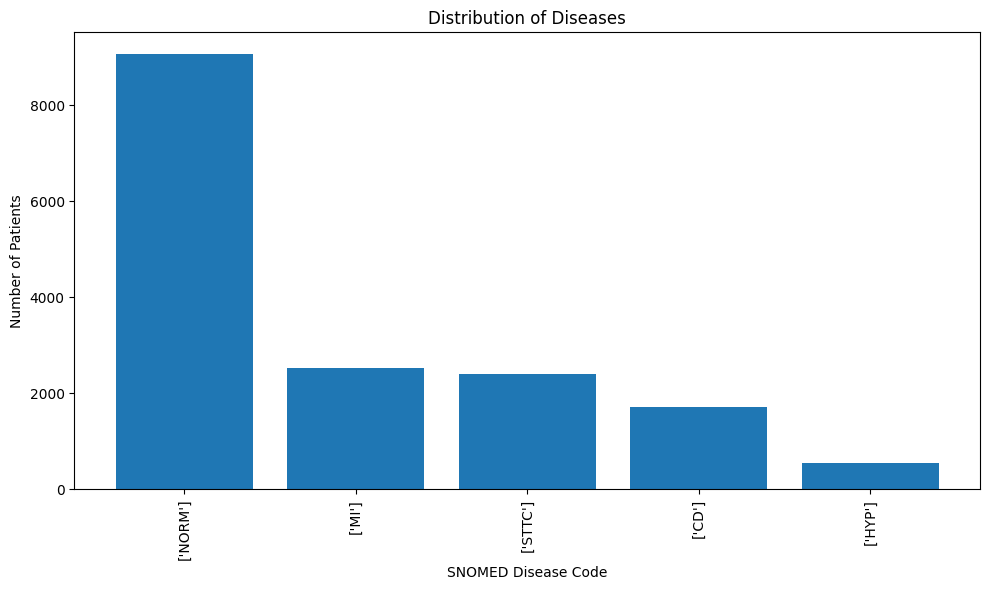

In [ ]:
# Dropping non-disease columns
df_diseases = df_encoded.drop(columns=['record_name', 'signal', 'age', 'sex'])

# Count the number of times each disease is there
disease_counts = (df_diseases == 1).sum()

# Sort the disease counts desc
disease_counts_sorted = disease_counts.sort_values(ascending=False)

disease_counts_sorted

plt.figure(figsize=(10, 6))

# Bar chart
plt.bar(disease_counts_sorted.index.astype(str), disease_counts_sorted.values)
plt.xlabel('SNOMED Disease Code')
plt.ylabel('Number of Patients')
plt.title('Distribution of Diseases')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## test display

250.0


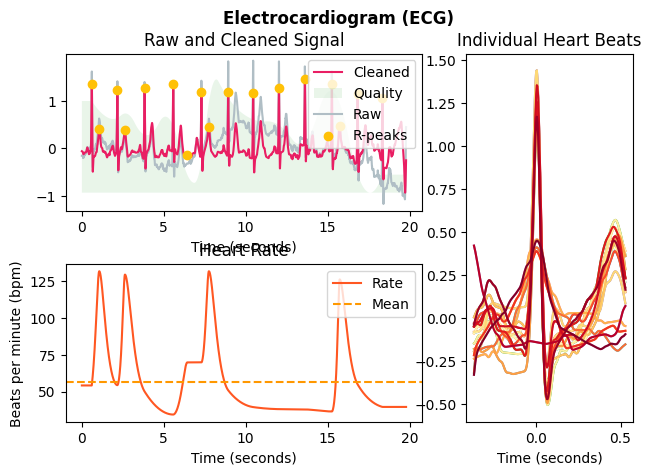

In [ ]:
single_ecg = []
for sublist in df_encoded.loc[3,'signal']: #FIRST PATIENT
    single_ecg.append(sublist[1]) # LEAD II 

#inverted_ecg = nk.ecg_invert(flat_list, sampling_rate=250)
signals, info = nk.ecg_process(single_ecg, sampling_rate=250)
rpeaks = info["ECG_R_Peaks"]
#cleaned_ecg = signals["ECG_Clean"]

# Segment the ECG into individual heartbeats using the R-peaks
heartbeats = np.split(single_ecg, rpeaks)

# TODO check accuracy sans enlever le dernier beat
# Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats])
print(average_heartbeat_length)

if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
    heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete

# Concatenate the heartbeats back into a single ECG signal
cleaned_ecg = np.concatenate(heartbeats)
signals, info = nk.ecg_process(cleaned_ecg, sampling_rate=250)

#plot = nk.events_plot(rpeaks, cleaned_ecg) #WHole ecg

#epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=250, show=True) # beatss superimposed

#nk.ecg_plot(signals, sampling_rate=250) # summary of ecg
nk.ecg_plot(signals, sampling_rate=250) # summary of ecg
# _, waves_peak = nk.ecg_delineate(signals, # PQRS peaks
#                                  rpeaks, 
#                                  sampling_rate=250, 
#                                  method="peak", 
#                                  show=True, 
#                                  show_type='peaks')


## Remove last beat if incomplete

In [ ]:
# cpt=0
# def clean_heartbeats(row):
#     global cpt
#     all_leads = []
#     for sublist in row['signal']:
#         all_leads.append(sublist)  # Get all leads 

#     # Process lead II to get R-peaks
#     single_ecg_lead_II = [sublist[1] for sublist in row['signal']]  # LEAD II 
#     try:
#         signals, info = nk.ecg_process(single_ecg_lead_II, sampling_rate=250)
#     except ValueError as e:
#         print(f"An error occurred while processing the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     rpeaks = info["ECG_R_Peaks"]
#     # Remove NaN values from rpeaks
#     rpeaks = rpeaks[~np.isnan(rpeaks)]
#     try:
#         heartbeats_II = np.split(single_ecg_lead_II, rpeaks.astype(int))
#     except ValueError as e:
#         print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     # Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
#     average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats_II])
#     if len(heartbeats_II[-1]) < average_heartbeat_length * 0.75:
#         rpeaks = rpeaks[:-1]  # Remove the last R-peak
#         cpt += 1

#     # Use the R-peaks to segment all leads and remove incomplete heartbeats
#     cleaned_ecg_leads = []
#     for lead in all_leads:
#         try:
#             heartbeats = np.split(lead, rpeaks.astype(int))
#         except ValueError as e:
#             print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#             return lead  # Return the original ECG signal if an error occurs

#         if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
#             heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete
#         # Concatenate the heartbeats back into a single ECG signal
#         cleaned_ecg_lead = np.concatenate(heartbeats)
#         cleaned_ecg_leads.append(cleaned_ecg_lead)

#     # Stack the cleaned leads back together
#     cleaned_ecg = np.stack(cleaned_ecg_leads, axis=-1)
#     return cleaned_ecg


# # Apply the function to the 'signal' column of the DataFrame
# df_encoded_removed_beats = df_encoded
# df_encoded_removed_beats['signal'] = df_encoded.apply(clean_heartbeats, axis=1)
# print(df_encoded_removed_beats)
# print(df_encoded_removed_beats['signal'][0])
# print(df_encoded_removed_beats['signal'][0][0])
# print(df_encoded_removed_beats['signal'][0][0][0])
# print(df_encoded_removed_beats.shape)
# print(f"number of incomplete beats patients: {cpt}/{len(df_encoded.index)}")
# df_encoded_removed_beats.to_pickle('df_encoded_removed_beats.pkl')



## Noise filtering

In [ ]:

# from scipy.signal import butter, lfilter, freqz, iirnotch

# # Define the sample rate and the frequencies for the notch and low-pass filters
# sample_rate = 250
# notch_freq = 50
# low_pass_freq = 150

# # Define a function to design the filters
# def design_filters(sample_rate, notch_freq, low_pass_freq):
#     # Design the notch filter
#     nyquist = 0.5 * sample_rate
#     freq_ratio = notch_freq / nyquist
#     notch_filter = iirnotch(freq_ratio, 30)  # 30 is the quality factor of the filter

#     # Design the low-pass filter
#     low_pass_filter = butter(5, low_pass_freq / nyquist, btype='low')

#     return notch_filter, low_pass_filter

# # Define a function to apply the filters
# def apply_filters(data, notch_filter, low_pass_filter):
#     # Apply the notch filter
#     data = lfilter(*notch_filter, data)

#     # Apply the low-pass filter
#     data = lfilter(*low_pass_filter, data)

#     return data

# # Design the filters
# notch_filter, low_pass_filter = design_filters(sample_rate, notch_freq, low_pass_freq)

# # Apply the filters to the data
# print(df_encoded.shape)
# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: apply_filters(signal, notch_filter, low_pass_filter))
# print(df_encoded.shape)


## Remove Outliers

In [ ]:

# # Compute the mean and standard deviation for each record
# means = np.array([np.mean(record) for record in df_encoded['signal']])
# std_devs = np.array([np.std(record) for record in df_encoded['signal']])

# # Compute the average mean and standard deviation
# avg_mean = np.mean(means)
# avg_std_dev = np.mean(std_devs)

# # Compute the standard deviation of the means and standard deviations
# std_mean = np.std(means)
# std_std_dev = np.std(std_devs)

# # Identify outliers as records where the mean or standard deviation is more than 3 standard deviations from the average
# outlier_indices = np.where(
#     (np.abs(means - avg_mean) > 3 * std_mean) | 
#     (np.abs(std_devs - avg_std_dev) > 3 * std_std_dev)
# )[0]

# # Remove outliers from df
# df_cleaned = df_encoded.drop(outlier_indices)
# print(df_cleaned.shape)
# print(len(df_cleaned['signal'][0]))
# print(df_cleaned['signal'][0][0])
df_cleaned = df_encoded


# Split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the target labels (heart condition classes) and the input features
X_ecg = np.array(df_cleaned['signal'].tolist())
X_info = df_cleaned[['age', 'sex']]  # age and sex as additional features
y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# Split the data into training, validation, and test sets
X_ecg_train, X_ecg_test, X_info_train, X_info_test, y_train, y_test = train_test_split(
    X_ecg, X_info, y, test_size=0.3, random_state=42
)
X_ecg_val, X_ecg_test, X_info_val, X_info_test, y_val, y_test = train_test_split(
    X_ecg_test, X_info_test, y_test, test_size=0.5, random_state=42
)

# Apply feature scaling (if needed) on the ECG signal data
scaler = StandardScaler()
X_ecg_train = np.array([scaler.fit_transform(sample) for sample in X_ecg_train])
X_ecg_val = np.array([scaler.transform(sample) for sample in X_ecg_val])
X_ecg_test = np.array([scaler.transform(sample) for sample in X_ecg_test])

# Check the shapes of the datasets
print("ECG Data Shapes:")
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)
print("\nInfo Data Shapes:")
print("Training data:", X_info_train.shape)
print("Validation data:", X_info_val.shape)
print("Test data:", X_info_test.shape)
print("\nTarget Labels Shape:")
print("Training labels:", y_train.shape)
print("Validation labels:", y_val.shape)
print("Test labels:", y_test.shape)


MemoryError: Unable to allocate 5.08 GiB for an array with shape (11370, 5000, 12) and data type float64

## Normalization 

In [ ]:

# # #TODO poorly done? does it work? try without?

# # Initialize a scaler
# scaler = MinMaxScaler()

# print(X_train.shape)

# # Fit the scaler to the training data and transform it
# X_train_scaled = [scaler.fit_transform(patient_data) for patient_data in X_train]

# # Transform the validation and test data
# X_val_scaled = [scaler.transform(patient_data) for patient_data in X_val]
# X_test_scaled = [scaler.transform(patient_data) for patient_data in X_test]



# CNN 


In [ ]:
# Define the ECG branch of the model
ecg_input = layers.Input(shape=(2500, 12))
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Define the additional features branch of the model
info_input = layers.Input(shape=(X_info_train.shape[1],))  # size of info data
info_layer = layers.Dense(16, activation='relu')(info_input)
info_layer = layers.Dropout(0.5)(info_layer)

# Concatenate the output of the two branches
concat_layer = layers.Concatenate()([ecg_layer, info_layer])

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(concat_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input, info_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1000, 12)]           0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 994, 64)              5440      ['input_5[0][0]']             
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, 331, 64)              0         ['conv1d_4[0][0]']            
 g1D)                                                                                             
                                                                                                  
 conv1d_5 (Conv1D)           (None, 325, 64)              28736     ['max_pooling1d_4[0][0]'

In [ ]:
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)


history = model.fit(
    [X_ecg_train, X_info_train], 
    y_train, 
    validation_data=([X_ecg_val, X_info_val], y_val),
    epochs=10,  # specify the number of epochs
    batch_size=32  # specify your batch size
)

Training data: (11370, 1000, 12)
Validation data: (2437, 1000, 12)
Test data: (2437, 1000, 12)


Epoch 1/10
356/356 [==============================] - 34s 84ms/step - loss: 1.1849 - categorical_accuracy: 0.5850 - val_loss: 0.9555 - val_categorical_accuracy: 0.6672
Epoch 2/10
356/356 [==============================] - 24s 69ms/step - loss: 0.9155 - categorical_accuracy: 0.6850 - val_loss: 0.8673 - val_categorical_accuracy: 0.7267
Epoch 3/10
356/356 [==============================] - 23s 65ms/step - loss: 0.8253 - categorical_accuracy: 0.7256 - val_loss: 0.8696 - val_categorical_accuracy: 0.7177
Epoch 4/10
356/356 [==============================] - 22s 60ms/step - loss: 0.7470 - categorical_accuracy: 0.7458 - val_loss: 0.8603 - val_categorical_accuracy: 0.7160
Epoch 5/10
356/356 [==============================] - 28s 80ms/step - loss: 0.7117 - categorical_accuracy: 0.7645 - val_loss: 0.8295 - val_categorical_accuracy: 0.7439
Epoch 6/10
356/356 [==============================] - 28s 78ms/step - loss: 0.6673 - categorical_accuracy: 0.7772 - val_loss: 0.8362 - val_categorical_accuracy:

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict([X_ecg_test, X_info_test])

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
# You may need to replace 'class_0', 'class_1', etc. with your actual class names
target_names = [f'class_{i}' for i in range(y_pred.shape[1])]
print(classification_report(y_test, y_pred_binary, target_names=target_names))


77/77 [==============================] - 2s 16ms/step
ROC AUC Score: 0.8910545752974969
              precision    recall  f1-score   support

     class_0       0.84      0.69      0.76       255
     class_1       0.00      0.00      0.00        99
     class_2       0.63      0.53      0.58       352
     class_3       0.85      0.78      0.81      1370
     class_4       0.58      0.50      0.54       361

   micro avg       0.78      0.66      0.71      2437
   macro avg       0.58      0.50      0.54      2437
weighted avg       0.74      0.66      0.70      2437
 samples avg       0.66      0.66      0.66      2437



C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_ecg_val, X_info_val], y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


77/77 [==============================] - 1s 15ms/step - loss: 3.6989 - categorical_accuracy: 0.4021
Test Loss: 3.6988866329193115
Test Accuracy: 0.4021337628364563


todo: 
 - complete preprocessing -> normalization, Noise Reduction, Outlier Removal,Data Augmentation,downsampling, invert? 
 - convert signal to spectogram 2D? (not 1D CNN raw data anymore, can be generated with STFT, 2D CNN) 1D simpler but 2D may perform better
 - remove diseases because accuracy is poor
 - rajouter age et sexe?
 - CNN prep, build, model train, evaluate
 - RNN
 - Transofrmer

 afficher metriques
 changer loss function
 superclasses

Done:
- remove last beat (when 0 volt)

tests with basic CNN, 1000 premiers:
- no normalize, no removal beat : 
- normalized, removed beat: 0.5
- normalized, no removed beat: 
- no normalized, removed beat: 0.51 (problem in normalization?)

